<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/computer_vision_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade

In [1]:
import fastai.vision.all as vision
import torch

import numpy as np
from PIL import Image
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [ ]:
path = vision.untar_data(vision.URLs.IMAGENETTE)
path.ls()

In [ ]:
path.ls()[0].ls()

In [3]:
def splitter(path): return str(path.parent.parent.name) == 'val'

db = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock),
    get_items=vision.get_image_files,
    get_y=vision.parent_label, 
    item_tfms=vision.Resize(460),
    batch_tfms=vision.aug_transforms(size=224, min_scale=0.75),
    splitter=vision.FuncSplitter(splitter)
)

In [7]:
ds = db.datasets(path)

In [ ]:
ds.train, ds.valid, ds.vocab

In [124]:
dls = db.dataloaders(path, bs=32)

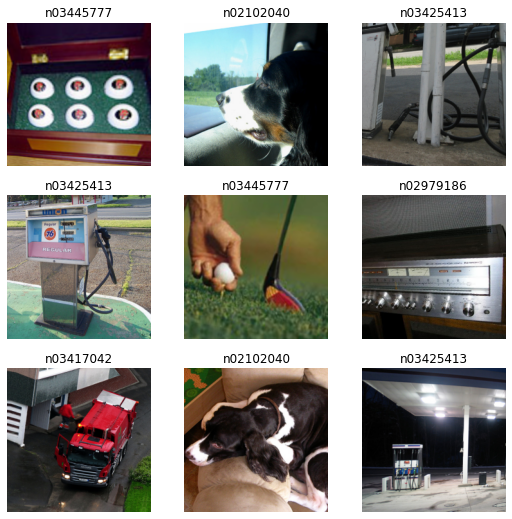

In [125]:
dls.show_batch()

In [129]:
learn = vision.Learner(dls, vision.xresnet50(), loss_func=torch.nn.CrossEntropyLoss(), metrics=vision.accuracy, pretrained=False)

In [130]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.658774,2.103384,0.401529,02:44
1,1.247024,2.213533,0.491210,02:40
2,0.914718,0.945459,0.707771,02:40
3,0.737189,0.707571,0.771720,02:40
4,0.621317,0.567915,0.819108,02:40


## Normalizing

In [138]:
db1 = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock),
    get_items=vision.get_image_files,
    get_y=vision.parent_label, 
    item_tfms=vision.Resize(460),
    batch_tfms=[*vision.aug_transforms(size=224, min_scale=0.75),
                vision.Normalize.from_stats(*vision.imagenet_stats)],
    splitter=vision.FuncSplitter(splitter)
)

In [ ]:
db1.summary(path)

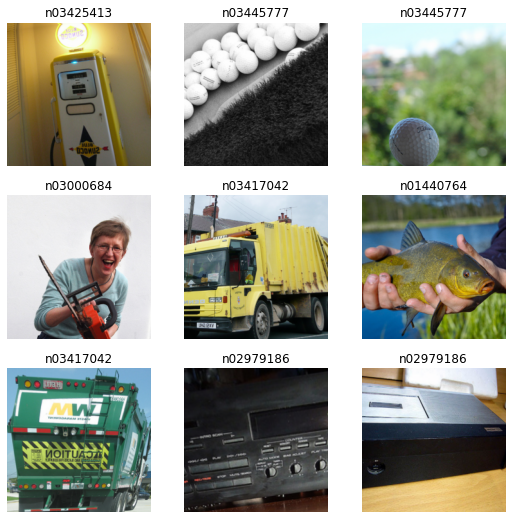

In [140]:
dls1 = db1.dataloaders(path, bs=32)
dls1.show_batch()

In [141]:
learn1 = vision.Learner(dls1, vision.xresnet50(), loss_func=vision.CrossEntropyLossFlat(), metrics=vision.accuracy)

In [142]:
learn1.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.829856,0.837526,0.725605,02:40
1,0.824502,1.359232,0.628025,02:41
2,0.652435,0.677327,0.786497,02:40
3,0.519262,0.505769,0.838981,02:40
4,0.443815,0.428318,0.863185,02:40


## Presizing

Progressive resizing

In [143]:
def get_dls(bs, size):
  db = vision.DataBlock(
      blocks=(vision.ImageBlock, vision.CategoryBlock),
      get_items=vision.get_image_files,
      get_y=vision.parent_label,
      splitter=vision.FuncSplitter(splitter),
      item_tfms=vision.Resize(460),
      batch_tfms=[*vision.aug_transforms(size=size, min_scale=0.75),
                  vision.Normalize.from_stats(*vision.imagenet_stats)]
  )

  return db.dataloaders(path, bs=bs)

In [145]:
dls = get_dls(32, 128)
learn = vision.Learner(dls, vision.xresnet50(), loss_func=vision.CrossEntropyLossFlat(), metrics=vision.accuracy)

In [146]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.722279,2.013101,0.432866,02:09
1,1.256942,1.393829,0.578599,02:07
2,0.900626,0.809706,0.746242,02:07
3,0.733233,0.689337,0.780382,02:07


In [148]:
learn.dls = get_dls(16, 224)
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.739479,0.866746,0.746242,02:48


epoch,train_loss,valid_loss,accuracy,time
0,0.678550,0.720628,0.776815,02:49
1,0.581601,0.513642,0.833121,02:50
2,0.449859,0.436976,0.862675,02:50


In [ ]:
pred, target = learn.tta()

In [152]:
vision.accuracy(pred, target).item()

0.8657324910163879

## Mix Up

In [25]:
img1 = Image.open(path.ls()[0].ls()[0].ls()[0]).resize((256, 256))
img2 = Image.open(path.ls()[0].ls()[1].ls()[1]).resize((256, 256))

golf = np.array(img1)
truck = np.array(img2)
adv_im = torch.from_numpy(0.4*golf)/255.0 + torch.from_numpy(0.6*truck)/255.0

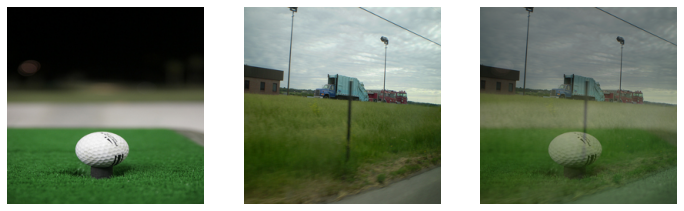

In [34]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))

vision.show_image(golf, ax=axs[0])
vision.show_image(truck, ax=axs[1])
vision.show_image(adv_im, ax=axs[2])

In [4]:
db = vision.DataBlock(
    blocks=(vision.ImageBlock, vision.CategoryBlock),
    get_items=vision.get_image_files,
    get_y=vision.parent_label, 
    item_tfms=vision.Resize(460),
    batch_tfms=vision.aug_transforms(size=224, min_scale=0.75),
    splitter=vision.FuncSplitter(splitter)
)

In [10]:
dls = db.dataloaders(path, bs=32)

In [19]:
learn = vision.Learner(dls, vision.xresnet50(), loss_func=vision.CrossEntropyLossFlat(), metrics=vision.accuracy)

In [20]:
learn.fit_one_cycle(1, 3e-3, cbs=vision.MixUp())

epoch,train_loss,valid_loss,accuracy,time
0,1.718072,1.311549,0.601783,02:35


## Label smoothing

In [21]:
learn = vision.Learner(dls, vision.xresnet50(), loss_func=vision.LabelSmoothingCrossEntropy(), metrics=vision.accuracy)
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.231875,2.110342,0.623185,02:34
